TRAINING A NEURAL NETWORK WITH DROPOUT

OUR DATASET

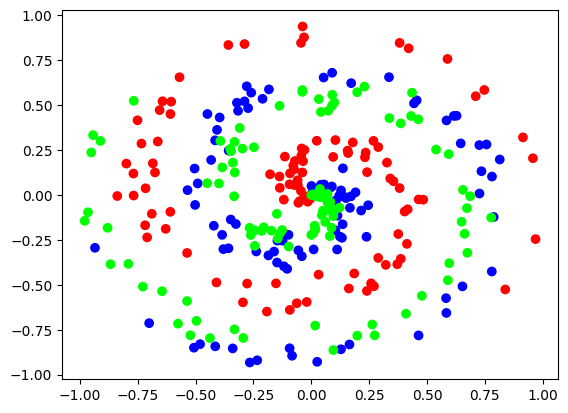

In [23]:
from nnfs.datasets import spiral_data
import numpy as np
import nnfs
nnfs.init()

import matplotlib.pyplot as plt

X,y = spiral_data(samples=100,classes=3)
plt.scatter(X[:,0],X[:,1],c=y,cmap='brg')
plt.show()

In [24]:
import numpy as np

class Layer_Dropout:
    # Initialize the dropout layer
    def __init__(self,rate):
        # Store the dropout rate, invert it to get the success rate
        # For example, for a dropout of 0.1, we need a success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self,inputs):
        # Save input values
        self.inputs = inputs
        # Generate and save the scaled binary mask
        self.binary_mask = np.random.binomial(1,self.rate,size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask

    # Backward pass
    def backward(self,dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask

TRAINING A NEURAL NETWORK WITH DROPOUT

OUR DATASET

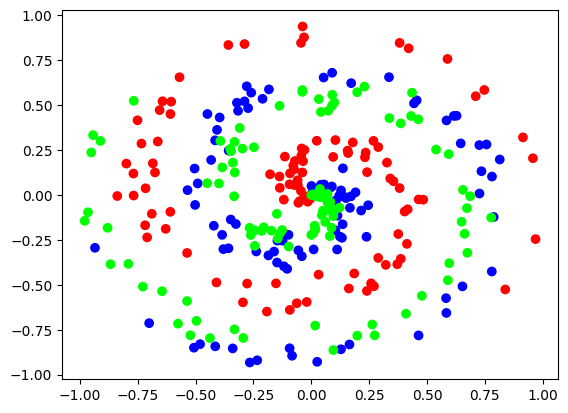

In [25]:
from nnfs.datasets import spiral_data
import numpy as np
import nnfs
nnfs.init()

import matplotlib.pyplot as plt

X,y = spiral_data(samples=100,classes=3)
plt.scatter(X[:,0],X[:,1],c=y,cmap='brg')
plt.show()

In [26]:
import numpy as np
from nnfs.datasets import spiral_data
import nnfs
nnfs.init()

# Dropout Layer
class Layer_Dropout:
    def __init__(self, rate):
        self.rate = 1 - rate  # success rate

    def forward(self, inputs, training=True):
        self.inputs = inputs
        if not training:
            self.output = inputs.copy()
            return
            
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        self.output = inputs * self.binary_mask

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

# Dense Layer
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, 
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # L1 regularization - weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        
        # L2 regularization - weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
            
        # L1 regularization - biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
            
        # L2 regularization - biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
            
        self.dinputs = np.dot(dvalues, self.weights.T)

# ReLU Activation
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

# Softmax Activation
class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

# Common Loss class
class Loss:
    def regularization_loss(self, layer):
        regularization_loss = 0
        
        # L1 regularization - weights
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
            
        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
            
        # L1 regularization - biases
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            
        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
            
        return regularization_loss
        
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
            
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
        
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
            
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

# Softmax classifier - combined Softmax activation and cross-entropy loss
class Activation_Softmax_Loss_CategoricalCrossentropy:
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)
        
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
            
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

# Adam optimizer
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        # Get corrected momentum
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))
        
        # Vanilla SGD parameter update + normalization with squared root cache
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1

# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create model with dropout
dense1 = Layer_Dense(2, 64)
activation1 = Activation_ReLU()
dropout1 = Layer_Dropout(0.1)  # 10% dropout rate
dense2 = Layer_Dense(64, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_Adam(learning_rate=0.02, decay=5e-7)

# Training loop
for epoch in range(10001):
    # Forward pass (with dropout)
    dense1.forward(X)
    activation1.forward(dense1.output)
    dropout1.forward(activation1.output, training=True)  # Enable dropout during training
    dense2.forward(dropout1.output)
    
    # Calculate loss
    data_loss = loss_activation.forward(dense2.output, y)
    regularization_loss = (
        loss_activation.loss.regularization_loss(dense1) + 
        loss_activation.loss.regularization_loss(dense2)
    )
    loss = data_loss + regularization_loss
    
    # Calculate accuracy
    predictions = np.argmax(loss_activation.output, axis=1)
    y_labels = np.argmax(y, axis=1) if len(y.shape) == 2 else y
    accuracy = np.mean(predictions == y_labels)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, acc: {accuracy:.3f}, loss: {loss:.3f} ' + 
              f'(data_loss: {data_loss:.3f}, reg_loss: {regularization_loss:.3f})')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    dropout1.backward(dense2.dinputs)  # Add dropout backward pass
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

# Validation (without dropout)
X_test, y_test = spiral_data(samples=100, classes=3)
dense1.forward(X_test)
activation1.forward(dense1.output)
dropout1.forward(activation1.output, training=False)  # Disable dropout for validation
dense2.forward(dropout1.output)
loss = loss_activation.forward(dense2.output, y_test)
predictions = np.argmax(loss_activation.output, axis=1)
y_test_labels = np.argmax(y_test, axis=1) if len(y_test.shape) == 2 else y_test
accuracy = np.mean(predictions == y_test_labels)
print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

epoch: 0, acc: 0.347, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000)
epoch: 100, acc: 0.553, loss: 0.927 (data_loss: 0.927, reg_loss: 0.000)
epoch: 200, acc: 0.580, loss: 0.844 (data_loss: 0.844, reg_loss: 0.000)
epoch: 300, acc: 0.567, loss: 0.802 (data_loss: 0.802, reg_loss: 0.000)
epoch: 400, acc: 0.627, loss: 0.787 (data_loss: 0.787, reg_loss: 0.000)
epoch: 500, acc: 0.617, loss: 0.791 (data_loss: 0.791, reg_loss: 0.000)
epoch: 600, acc: 0.670, loss: 0.764 (data_loss: 0.764, reg_loss: 0.000)
epoch: 700, acc: 0.630, loss: 0.809 (data_loss: 0.809, reg_loss: 0.000)
epoch: 800, acc: 0.633, loss: 0.743 (data_loss: 0.743, reg_loss: 0.000)
epoch: 900, acc: 0.647, loss: 0.777 (data_loss: 0.777, reg_loss: 0.000)
epoch: 1000, acc: 0.607, loss: 0.800 (data_loss: 0.800, reg_loss: 0.000)
epoch: 1100, acc: 0.627, loss: 0.785 (data_loss: 0.785, reg_loss: 0.000)
epoch: 1200, acc: 0.620, loss: 0.777 (data_loss: 0.777, reg_loss: 0.000)
epoch: 1300, acc: 0.660, loss: 0.721 (data_loss: 0.721, reg_los